<a href="https://colab.research.google.com/github/falawar7/AAI614_ELAWAR/blob/main/Week7/FE_Notebook7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI614: Data Science & its Applications

*Notebook 7.3: Dask-ML*

Source: Data Science with Python and Dask

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://snap.stanford.edu/data/finefoods.txt.gz sample_data/food

--2024-12-09 22:07:50--  https://snap.stanford.edu/data/finefoods.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122104202 (116M) [application/x-gzip]
Saving to: ‘finefoods.txt.gz’

finefoods.txt.gz    100%[===================>] 116.45M  36.2MB/s    in 4.7s    

2024-12-09 22:07:55 (24.5 MB/s) - ‘finefoods.txt.gz’ saved [122104202/122104202]

--2024-12-09 22:07:55--  http://sample_data/food
Resolving sample_data (sample_data)... failed: Name or service not known.
wget: unable to resolve host address ‘sample_data’
FINISHED --2024-12-09 22:07:55--
Total wall clock time: 5.1s
Downloaded: 1 files, 116M in 4.7s (24.5 MB/s)


In [ ]:
import gzip

with gzip.open('finefoods.txt.gz', 'rb') as f_in, open('finefoods.txt', 'wb') as f_out:
    f_out.write(f_in.read())

In [ ]:
import pandas as pd

# Read the tab-separated data, specifying the encoding
# or 'cp1252
df = pd.read_csv('/content/finefoods.txt.gz', sep='\t', encoding='latin-1') '

# Display the first few rows
print(df.head())

    product/productId: B001E4KFG0
0   review/userId: A3SGXH7AUHU8GW
1  review/profileName: delmartian
2         review/helpfulness: 1/1
3               review/score: 5.0
4         review/time: 1303862400


In [3]:
raw_data = bag.read_text('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/finefoods.txt.gz')
print(raw_data.take(5))

NameError: name 'bag' is not defined

In [2]:
!pip install dask

In [4]:
import dask.bag as bag
import os
from dask.diagnostics import ProgressBar

# Get the foods dataset from https://snap.stanford.edu/data/web-FineFoods.html
raw_data = bag.read_text('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/finefoods.txt')

def get_next_part(file, start_index, span_index=0, blocksize=1024):
    file.seek(start_index)
    buffer = file.read(blocksize + span_index).decode('cp1252')
    delimiter_position = buffer.find('\n\n')
    if delimiter_position == -1:
        return get_next_part(file, start_index, span_index + blocksize)
    else:
        file.seek(start_index)
        return start_index, delimiter_position

def get_item(filename, start_index, delimiter_position, encoding='cp1252'):
    with open(filename, 'rb') as file_handle:
        file_handle.seek(start_index)
        text = file_handle.read(delimiter_position).decode(encoding)
        elements = text.strip().split('\n')
        key_value_pairs = [(element.split(': ')[0], element.split(': ')[1])
                               if len(element.split(': ')) > 1
                               else ('unknown', element)
                               for element in elements]
        return dict(key_value_pairs)

with open('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/finefoods.txt', 'rb') as file_handle:
    size = file_handle.seek(0,2) - 1
    more_data = True
    output = []
    current_position = next_position = 0
    while more_data:
        if current_position >= size:
            more_data = False
        else:
            current_position, next_position = get_next_part(file_handle, current_position, 0)
            output.append((current_position, next_position))
            current_position = current_position + next_position + 2

reviews = bag.from_sequence(output).map(lambda x: get_item('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/finefoods.txt', x[0], x[1]))

def tag_positive_negative_by_score(element):
    if float(element['review/score']) > 3:
        element['review/sentiment'] = 'positive'
    else:
        element['review/sentiment'] = 'negative'
    return element

tagged_reviews = reviews.map(tag_positive_negative_by_score)

In [5]:
!pip install nltk

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from functools import partial

#Added stopwards
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')

def extract_reviews(element):
    element['review/tokens'] = element['review/text'].lower()
    return element

def tokenize_reviews(element):
    element['review/tokens'] = tokenizer.tokenize(element['review/tokens'])
    return element

def filter_stopword(word, stopwords):
    return word not in stopwords

def filter_stopwords(element, stopwords):
    element['review/tokens'] = list(filter(partial(filter_stopword, stopwords=stopwords), element['review/tokens']))
    return element

stopword_set = set(stopwords.words('english'))
more_stopwords = {'br', 'amazon', 'com', 'http', 'www', 'href', 'gp'}
all_stopwords = stopword_set.union(more_stopwords)

review_extracted_text = tagged_reviews.map(extract_reviews)
review_tokens = review_extracted_text.map(tokenize_reviews)
review_text_clean = review_tokens.map(partial(filter_stopwords, stopwords=all_stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def extract_tokens(element):
    return element['review/tokens']

extracted_tokens = review_text_clean.map(extract_tokens)
unique_tokens = extracted_tokens.flatten().distinct()

with ProgressBar():
    number_of_tokens = unique_tokens.count().compute()
number_of_tokens

[########################################] | 100% Completed | 501.70 s


114290

In [9]:
# Listing 10.4
def count(accumulator, element):
    return accumulator + 1

def combine(total_1, total_2):
    return total_1 + total_2

with ProgressBar():
    token_counts = extracted_tokens.flatten().foldby(lambda x: x, count, 0, combine, 0).compute()

top_tokens = sorted(token_counts, key=lambda x: x[1], reverse=True)
top_100_tokens = list(map(lambda x: x[0], top_tokens[:100]))

[########################################] | 100% Completed | 505.43 s


In [10]:
import numpy as np
def vectorize_tokens(element):
    vectorized_tokens = np.where(np.isin(top_100_tokens, element['review/tokens']), 1, 0)
    element['review/token_vector'] = vectorized_tokens
    return element

def prep_model_data(element):
    return {'target': 1 if element['review/sentiment'] == 'positive' else 0,
            'features': element['review/token_vector']}

model_data = review_text_clean.map(vectorize_tokens).map(prep_model_data)

model_data.take(5)

({'target': 1,
  'features': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])},
 {'target': 0,
  'features': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 {'target': 1,
  'features': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

In [11]:
from dask import array as dask_array
def stacker(partition):
    return dask_array.concatenate([element for element in partition])

with ProgressBar():
    feature_arrays = model_data.pluck('features').map(lambda x: dask_array.from_array(x, 1000).reshape(1,-1)).reduction(perpartition=stacker, aggregate=stacker)
    feature_array = feature_arrays.compute()
feature_array

[########################################] | 100% Completed | 13m 7s


dask.array<concatenate, shape=(568454, 100), dtype=int64, chunksize=(1, 100), chunktype=numpy.ndarray>

In [12]:
!pip install zarr

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=26caae3dc9d0eb658a9c33754628df6762a6e1e0580257fc9fbf82470c63c9b5
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [13]:
with ProgressBar():
    feature_array.rechunk(5000).to_zarr('sentiment_feature_array.zarr')
    feature_array = dask_array.from_zarr('sentiment_feature_array.zarr')

with ProgressBar():
    target_arrays = model_data.pluck('target').map(lambda x: dask_array.from_array(x, 1000).reshape(-1,1)).reduction(perpartition=stacker, aggregate=stacker)
    target_arrays.compute().rechunk(5000).to_zarr('sentiment_target_array.zarr')
    target_array = dask_array.from_zarr('sentiment_target_array.zarr')

[########################################] | 100% Completed | 11m 30s
[########################################] | 100% Completed | 527.36 s
[########################################] | 100% Completed | 470.00 s


In [15]:
!pip install dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.6 MB/s eta 0:00:00


In [16]:
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split

X = feature_array
y = target_array.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()

with ProgressBar():
    lr.fit(X_train, y_train)

[########################################] | 100% Completed | 851.93 ms
[#############                           ] | 34% Completed | 670.72 ms

/usr/local/lib/python3.10/dist-packages/dask_glm/utils.py:66: RuntimeWarning: overflow encountered in exp
  return np.exp(A)


[########################################] | 100% Completed | 4.56 s
[########################################] | 100% Completed | 4.49 s
[########################################] | 100% Completed | 4.54 s
[########################################] | 100% Completed | 4.53 s
[########################################] | 100% Completed | 4.56 s
[########################################] | 100% Completed | 4.55 s
[########################################] | 100% Completed | 4.53 s
[########################################] | 100% Completed | 4.55 s
[########################################] | 100% Completed | 4.59 s
[########################################] | 100% Completed | 4.51 s
[########################################] | 100% Completed | 4.50 s
[########################################] | 100% Completed | 4.50 s
[########################################] | 100% Completed | 4.57 s
[########################################] | 100% Completed | 4.56 s
[#################################

In [17]:
lr.score(X_test, y_test).compute()

0.7968370685712275

In [21]:
from sklearn.naive_bayes import BernoulliNB
from dask_ml.wrappers import Incremental

nb = BernoulliNB()

parallel_nb = Incremental(nb)

with ProgressBar():
    parallel_nb.fit(X_train, y_train, classes=[0,1])

[########################################] | 100% Completed | 1.67 s


In [22]:
parallel_nb.score(X_test, y_test)

0.7898356964430215

In [23]:
from dask_ml.model_selection import GridSearchCV

parameters = {'penalty': ['l1', 'l2'], 'C': [0.5, 1, 2]}

lr = LogisticRegression()
tuned_lr = GridSearchCV(lr, parameters)

with ProgressBar():
    tuned_lr.fit(X_train, y_train)

[########################################] | 100% Completed | 331.25 s
[########################################] | 100% Completed | 198.92 s


In [24]:
import pandas as pd
pd.DataFrame(tuned_lr.cv_results_)

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_C,param_penalty
0,"{'C': 0.5, 'penalty': 'l1'}",327.747198,1.735357,0.162804,0.037626,0.790660,0.794090,0.796506,0.793752,0.002399,1,0.5,l1
1,"{'C': 0.5, 'penalty': 'l2'}",72.545755,0.477671,0.261724,0.078786,0.790836,0.793821,0.796477,0.793711,0.002304,2,0.5,l2
2,"{'C': 1, 'penalty': 'l1'}",316.029191,9.179315,0.197931,0.028634,0.790736,0.793668,0.796483,0.793629,0.002346,6,1,l1
3,"{'C': 1, 'penalty': 'l2'}",49.505143,1.022170,0.261744,0.027988,0.790836,0.793821,0.796477,0.793711,0.002304,2,1,l2
4,"{'C': 2, 'penalty': 'l1'}",196.782376,9.978761,0.252853,0.014787,0.790707,0.793727,0.796512,0.793649,0.002371,5,2,l1
5,"{'C': 2, 'penalty': 'l2'}",44.904899,0.615832,0.325508,0.046607,0.790836,0.793821,0.796477,0.793711,0.002304,2,2,l2


In [26]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.3 MB/s eta 0:00:00


In [27]:
import dill
with open('naive_bayes_model.pkl', 'wb') as file:
    dill.dump(parallel_nb, file)

In [28]:
with open('naive_bayes_model.pkl', 'rb') as file:
    nb = dill.load(file)
nb.predict(np.random.randint(0,2,(100,100)))

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[########################################] | 100% Completed | 328.20 s
[########################################] | 100% Completed | 144.31 s
Best hyperparameters found: {'C': 0.5, 'penalty': 'l1'}


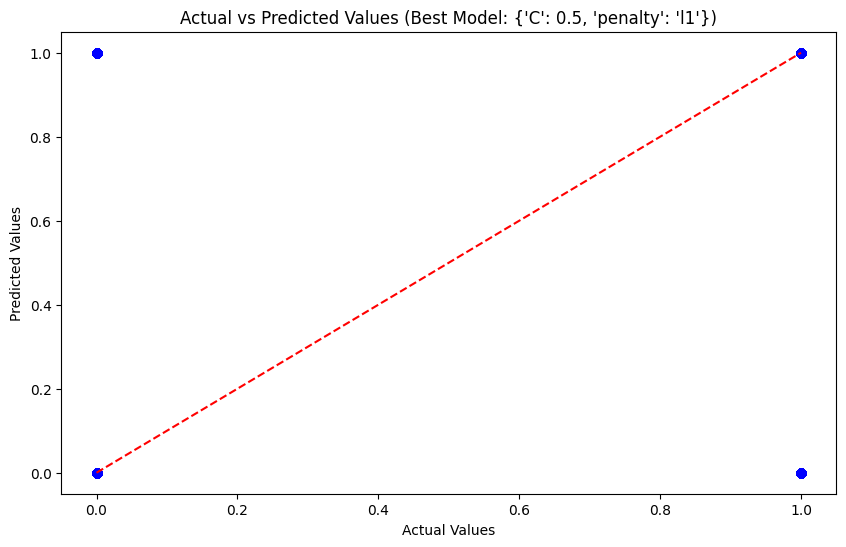

In [30]:
# Set the parameters for GridSearchCV
parameters = {'penalty': ['l1', 'l2'], 'C': [0.5, 1, 2]}

# Initialize GridSearchCV with Logistic Regression and the parameter grid
tuned_lr = GridSearchCV(lr, parameters)

# Perform GridSearchCV with a ProgressBar to show progress
with ProgressBar():
    tuned_lr.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = tuned_lr.best_params_
print("Best hyperparameters found:", best_params)

# Get the predictions using the best model
y_pred = tuned_lr.predict(X_test)

# Plotting the actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test.compute(), y_pred.compute(), color='blue', alpha=0.5)
plt.plot([min(y_test.compute()), max(y_test.compute())], [min(y_test.compute()), max(y_test.compute())], color='red', linestyle='--')  # Diagonal line
plt.title(f"Actual vs Predicted Values (Best Model: {best_params})")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()